# Combine figure diseases MLR and Cox
## UNFINISHED

Last modification: 19/10/2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statsmodels.formula.api import ols, logit
from datetime import datetime
import seaborn as sns

DATE = datetime.now().strftime("%Y-%m-%d")

In [5]:
file_info_name='pheno_info_main.csv'
pheno_info_file = '/SSD/home/sofia/retina-phenotypes/complementary/disease_association/'+str(file_info_name)
display_info=True
ventile='ventile2'
diseases_file ='/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/diseases_cov/2022_07_08_'+str(ventile)+'_diseases_cov.csv'
pheno_file ='/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/participant_phenotype/2022_08_03_'+str(ventile)+'_corrected_z.csv'
output_dir ='/SSD/home/sofia/retina-phenotypes/complementary/disease_association/'

In [11]:
betas=pd.read_csv(output_dir+'reg_betas_'+ventile+'.csv', index_col=0)
log10p=pd.read_csv(output_dir+'reg_log10p_'+ventile+'.csv', index_col=0)

In [13]:
betas = betas.astype('float64') # in case betas was coded as object type

[Text(0.5, 0, 'DBP'),
 Text(1.5, 0, 'SBP'),
 Text(2.5, 0, 'PR'),
 Text(3.5, 0, 'birth_weight'),
 Text(4.5, 0, 'alcohol_intake_frequency_00'),
 Text(5.5, 0, 'pulse_wave_arterial_stiffness_index_00'),
 Text(6.5, 0, 'age_death'),
 Text(7.5, 0, 'BMI'),
 Text(8.5, 0, 'N_cigarettes_curr_daily'),
 Text(9.5, 0, 'Pack_year_smok'),
 Text(10.5, 0, 'date_AD'),
 Text(11.5, 0, 'HDL_cholesterol'),
 Text(12.5, 0, 'LDL_direct'),
 Text(13.5, 0, 'Triglycerides'),
 Text(14.5, 0, 'HbA1c'),
 Text(15.5, 0, 'age_diabetes_00'),
 Text(16.5, 0, 'age_angina_00'),
 Text(17.5, 0, 'age_heartattack_00'),
 Text(18.5, 0, 'age_DVT_00'),
 Text(19.5, 0, 'age_stroke_00'),
 Text(20.5, 0, 'age_glaucoma_00'),
 Text(21.5, 0, 'age_cataract_00'),
 Text(22.5, 0, 'eye_amblyopia_00'),
 Text(23.5, 0, 'eye_presbyopia_00'),
 Text(24.5, 0, 'eye_hypermetropia_00'),
 Text(25.5, 0, 'eye_myopia_00'),
 Text(26.5, 0, 'eye_astigmatism_00'),
 Text(27.5, 0, 'eye_diabetes_00'),
 Text(28.5, 0, 'age_other_serious_eye_condition_00'),
 Text(29.5, 0,

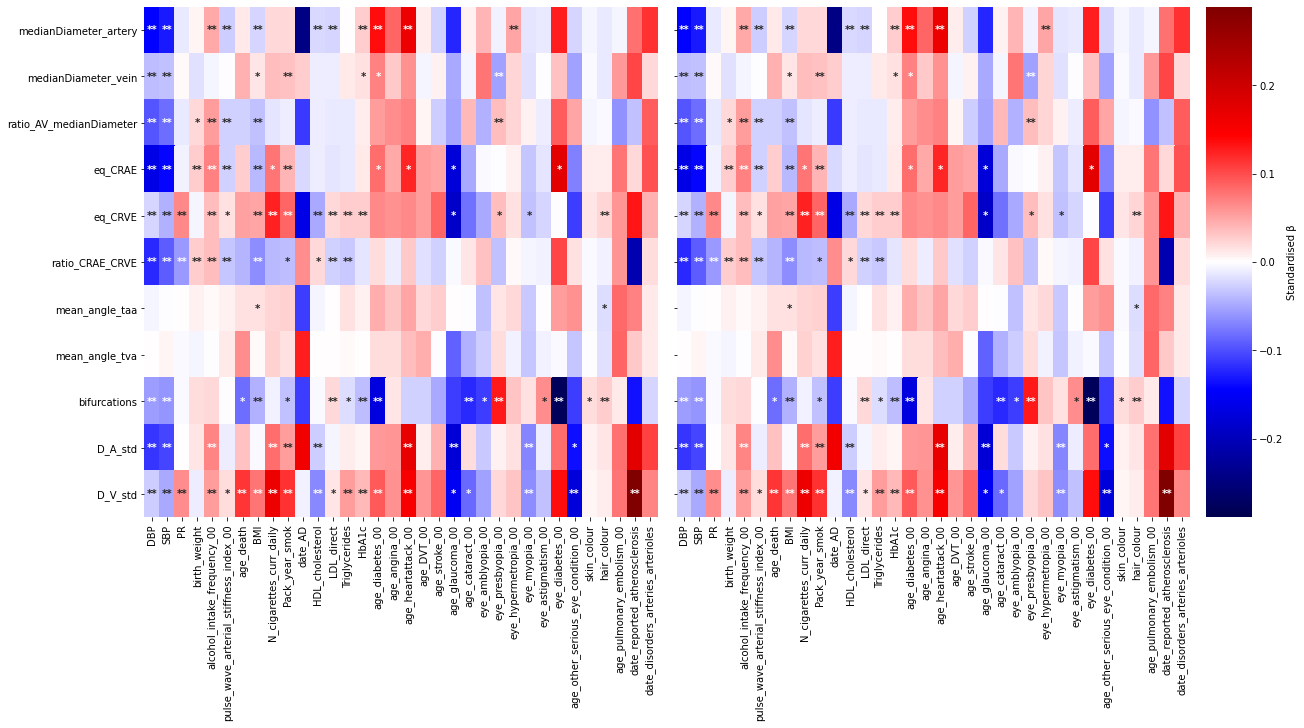

In [15]:
## This colours by beta and annotates Bonferroni-significant models with an asterisk
Bonf_thresh = -np.log10(0.05 / (log10p.shape[0] * log10p.shape[1]))
Bonf_thresh2 = -np.log10(0.001 / (log10p.shape[0] * log10p.shape[1]))

log10p_copy = log10p.copy()
log10p_copy2 = log10p.copy()
log10p_copy3 = log10p.copy()

log10p_copy= (log10p_copy>Bonf_thresh).replace({True:'*', False:''})
log10p_copy2= (log10p_copy2>Bonf_thresh2).replace({True:'*', False:''})
log10p_copy3 =log10p_copy+log10p_copy2

#img1 = mpimg.imread('2022-10-19_MLR_ventile5.jpg')
#img2 = mpimg.imread('2022-10-19_MLR_ventile5.jpg')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(18, 10))
plt.rcParams['figure.constrained_layout.use'] = True
#ax1.yaxis.set_ticks_position('right')

fig1 = sns.heatmap(betas, 
            annot=log10p_copy3, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            cbar=False,
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas).max().max(), 
            vmax=abs(betas).max().max(), 
            cmap='seismic', cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax1)
fig1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)

########### TO DO: change this figure by COX FIGURE
#ax2.yaxis.set_ticks_position('right')
fig2 = sns.heatmap(betas, 
            annot=log10p_copy3, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
            #cbar=False,
            fmt="", annot_kws={'weight': 'bold'}, 
            vmin=-abs(betas).max().max(), 
            vmax=abs(betas).max().max(), 
            cmap='seismic', cbar_kws={'label': 'Standardised \u03B2'},
               ax=ax2)
fig2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)


### cases and controls

In [146]:
list_value=[]
for i in log10p_copy3.columns:
    #print(i, df_pheno_dise[i].value_counts())
    data={
        'i': i,
        'value_counts': df_pheno_dise[i].value_counts()
    }
    list_value.append(data)
df_count_val = pd.DataFrame(list_value)
print(df_count_val)
df_count_val.to_csv(output_dir+ str(DATE)+'_N_CASES_MLR_'+ventile+'.csv', sep=',', index=False)


                                         i  \
0                                      DBP   
1                                      SBP   
2                                       PR   
3            date_reported_atherosclerosis   
4       date_disorders_arteries_arterioles   
5   pulse_wave_arterial_stiffness_index_00   
6                          HDL_cholesterol   
7                               LDL_direct   
8                            Triglycerides   
9                                    HbA1c   
10             alcohol_intake_frequency_00   
11                          Pack_year_smok   
12                        eye_amblyopia_00   
13                       eye_presbyopia_00   
14                    eye_hypermetropia_00   
15                           eye_myopia_00   
16                      eye_astigmatism_00   
17                         eye_diabetes_00   
18                                     BMI   

                                         value_counts  
0   -0.174140    1563
 